# 딥러닝_자연어_자동분류

참조1: fastai version 1.0.60, https://github.com/fastai/fastai

참조2:Jeremy Howard, Sebastian Ruder, “Universal Language Model Fine-tuning for Text Classification”, 2018, https://arxiv.org/abs/1801.06146 

참조3: https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83

In [ ]:
# Python 버젼
!python --version
# OS 플랫폼 
!cat /etc/issue.net
# CPU 사양
!head /proc/cpuinfo
# 메모리 사양 - 14Gb
!head -n 3 /proc/meminfo
# 디스크 사양 - 
!df -h
# Tensorflow 버젼
import tensorflow as tf
print(tf.__version__)
# GPU 모니터링 -  K80 GPU(GPU 11.4GB)
## 12간 동안만 무료로 사용
!nvidia-smi

Python 3.6.9
Ubuntu 18.04.3 LTS
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.170
cache size	: 39424 KB
physical id	: 0
MemTotal:       13333556 kB
MemFree:        10333576 kB
MemAvailable:   12451876 kB
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   32G   34G  49% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   33G   43G  44% /opt/bin
tmpfs           6.4G   16K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
2.2.0-rc2
Mon Apr 13 16:12:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|------

## 데이터 전처리





In [ ]:
import fastai.text

fastai.text.__version__

'1.0.60'

In [ ]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
# Optional: use this line if you want to remove Pandas'
# default concatenation of long text in columns
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [ ]:
# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 학생들이 실제로 변경해야될 유일한 부분

In [ ]:
# 문서 ID로 실제 파일 불러오는 법
## https://drive.google.com/open?id=1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV

# https://drive.google.com/open?id=1MpUKKtp7OJntMzU4nI097gtk3RUoNsw5
###label,text
###긍정,어릴때보고 지금다시봐도 재밌어요ㅋㅋ
###긍정,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다."
###긍정,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
###부정,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.
###부정,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
###부정,포풍저그가나가신다영차영차영차

# 실습을 위한 간단 데이터 - 긍정 100개 부정 100개
# https://drive.google.com/open?id=1pHM41cWacOvMT5bl7TGTmxMLL_tl6M6n
rawdata_downloaded = drive.CreateFile({'id': '1MpUKKtp7OJntMzU4nI097gtk3RUoNsw5'})
rawdata_downloaded.GetContentFile('rawdata.txt')

## 하단은 Full DATA - 긍정 99,996개 부정 99,996개
## https://drive.google.com/open?id=1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV
#rawdata_downloaded = drive.CreateFile({'id': '1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV'})
#rawdata_downloaded.GetContentFile('rawdata.txt')

## 실행

In [ ]:
# 파일을 DataFrame으로 전환
df = pd.read_csv('rawdata.txt', header=0, encoding='utf-8', dtype=str, engine='python')

In [ ]:
df

,label,text
0,1점,이건 절대로 1점이 아니다. 11점을 주고 싶은 내 마음이다.
1,1점,엄복동은 시간 없어서 피했는 데 리얼은 못 피했다...ㅅㅂ
2,1점,진짜 하나도 빠짐없이 개망작ㅎㅎ 내가 이걸 왜 봤지^^ 만약 할리우드처럼 최악의 배우상 있었으면 2017년도는 김수현이였음ㅎㅎ
3,1점,감독뭐냐무슨내용인지1도모르것다
4,1점,감독의 클럽 사랑을 볼수 있는 영화
...,...,...
196,10점,이 감동 지인들과 함께 나누세요
197,10점,일본에서 개봉한다네여 그건 괜잖은듯ㅋㅋㅋ 일본이 한국 생각만해도 떨수있게 해줄듯ㅋㅋ
198,10점,한국 영화에 앞장 서는 좋은 영화 라고 생각 한다.
199,10점,제가 10점을 영화에 주는게 아닙니다.이 영화를 관람하신분들이 승리자여서 그분들께 드리는겁니다.


In [ ]:
# 동일한 의미를 갖는, 다른 방법
df["label"].groupby([df["label"]]).count()

label
10점    99 
1점     102
Name: label, dtype: int64

## Create train & validation datasets and FastAI data bunch

In [ ]:
from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3) ## 학습:테스트 비율 설정 
df_trn.shape, df_val.shape

((140, 2), (61, 2))

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [ ]:
data_clas.show_batch()

text,target
xxbos 정말 감독이 영화에 모든 걸 xxunk xxunk xxunk 이런 xxunk ? ? xxunk xxunk xxunk xxunk xxunk xxunk xxunk . xxunk 건 다 xxunk ... xxunk xxunk 뭔가 xxunk xxunk xxunk 것 xxunk xxunk,1점
xxbos xxunk ... xxunk xxunk xxunk xxunk 영화가 그냥 xxunk xxunk xxunk 그냥 xxunk xxunk xxunk xxunk ... 솔직히 뭐라 xxunk xxunk 영화네요 ... xxunk xxunk xxunk xxunk 너무 xxunk ...,1점
xxbos xxunk xxunk xxunk xxunk .. xxunk xxunk xxunk xxunk xxunk .. xxunk 봤는데 .. 무슨 내용인지 하나도 xxunk xxunk .. xxunk xxunk xxunk xxunk 김수현 xxunk xxunk 봤습니다 ...,1점
xxbos 평점 xxunk xxunk 사람들은 너무 xxunk xxunk 최고의 xxunk 보고 xxunk 거지 .. 클레멘타인 xxunk 처음 xxunk xxunk xxunk xxunk xxunk xxunk xxunk . xxunk xxunk xxunk xxunk ?,10점
"xxbos 내가 xxunk 이 영화에 xxunk 걸 xxunk xxunk 많이 xxunk 것 xxunk . xxunk xxunk xxunk 건 xxunk xxunk , xxunk xxunk xxunk 역시 xxunk xxunk 너무 xxunk .",1점


## Create and Train the Language Model

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.31E-01


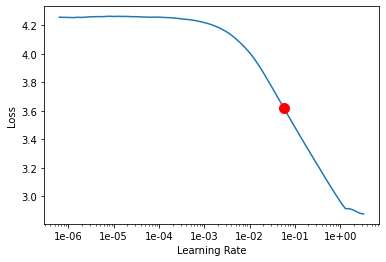

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(2, min_grad_lr) 

epoch,train_loss,valid_loss,accuracy,time
0,4.250350,3.700044,0.398438,00:00
1,4.192173,3.085863,0.587277,00:00


In [ ]:
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.453903,3.014847,0.588616,00:00
1,3.400450,2.803996,0.437277,00:00


In [ ]:
learn.predict("어려셔", n_words=10) ## 테스트

'어려셔 , 김수현이랑 ! ! .. ..'

In [ ]:
learn.save_encoder('ft_enc')

## Using the Language Model to Train the Classifier

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (140 items)
x: TextList
xxbos 뭔가 xxunk xxunk 시간 아까운 영화,xxbos 클레멘타인을 잇는 희대의 xxunk xxunk xxunk xxunk xxunk xxunk xxunk 보세요,xxbos 이거 xxunk xxunk 영화 xxunk ?,xxbos xxunk 김수현의 xxunk xxunk xxunk xxunk ...,xxbos 영화 xxunk xxunk xxunk 영화 ...
y: CategoryList
1점,10점,1점,10점,10점
Path: .;

Valid: LabelList (61 items)
x: TextList
xxbos xxunk xxunk xxunk 내가 xxunk xxunk xxunk xxunk xxunk xxunk 하고 xxunk 영화,xxbos 영화 xxunk xxunk xxunk 보세요 ... xxunk xxunk xxunk xxunk ... ㅋㅋㅋ,xxbos 이 영화를 보고 xxunk xxunk xxunk . xxunk,xxbos xxunk xxunk 더 xxunk .,xxbos 진짜 xxunk xxunk xxunk 보세요 xxunk xxunk xxunk xxunk xxunk ㅋㅋㅋ xxunk xxunk xxunk
y: CategoryList
1점,10점,10점,10점,10점
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(120, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(120, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
       

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.74E-02


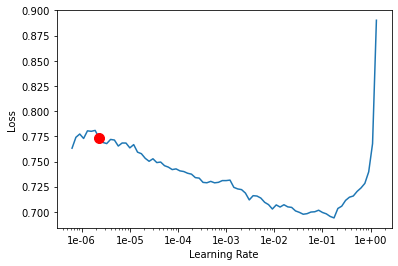

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.736671,0.696261,0.508197,00:00
1,0.778866,0.695467,0.508197,00:00


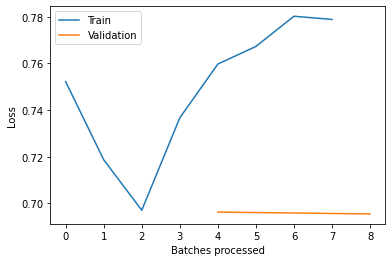

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.693267,0.686779,0.557377,00:00
1,0.704138,0.655328,0.639344,00:00
2,0.681973,0.643312,0.704918,00:00
3,0.682880,0.633324,0.737705,00:00


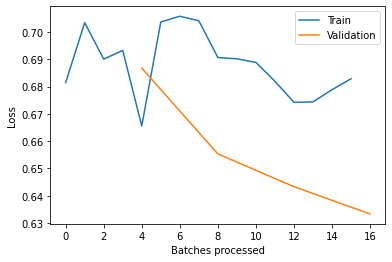

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.651848,0.633732,0.688525,00:00
1,0.637455,0.636703,0.655738,00:00
2,0.622669,0.646399,0.639344,00:00
3,0.645113,0.644460,0.622951,00:00


## Analyzing our results

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0, flags=flags)


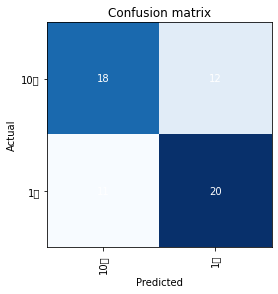

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[('10점', '1점', 12), ('1점', '10점', 11)]

## Predictions!

In [ ]:
learn.predict("최고의 망작!! 꼭 보세요!!")

(Category 10점, tensor(0), tensor([0.7023, 0.2977]))

In [ ]:
learn.predict("알 수 없는 감독의 뇌구조")

(Category 1점, tensor(1), tensor([0.3934, 0.6066]))

## Export the model

In [ ]:
## export.pkl / 170M
learn.export()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# copy it there
!cp export.pkl "/content/gdrive/My Drive"

## Import the model

In [ ]:
# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
## 실습_한국외대_딥러닝문서분류_네이버영화긍부정_82.export.pkl
## https://drive.google.com/open?id=1f7pvXQr80hvCiUywS1Yv-rZ10k97o7Za
rawdata_downloaded = drive.CreateFile({'id': '1f7pvXQr80hvCiUywS1Yv-rZ10k97o7Za'})
rawdata_downloaded.GetContentFile('네이버영화긍부정_82.export.pkl')

In [ ]:
## 가장 좋은 학습 모델 불러오기
path = learn.path
learnx = load_learner(path,'네이버영화긍부정_82.export.pkl')

In [ ]:
learnx.predict("단연 최고")

(Category 긍정, tensor(0), tensor([0.9688, 0.0312]))

In [ ]:
learnx.predict("영상은 좋으나 반전까지 보기엔 산만하고 지루하고 개연성이떨어진다.. 평점에낚였네")

(Category 부정, tensor(1), tensor([0.0187, 0.9813]))